In [1]:
# this notebook is a modifier of pretrain_trainXbias notebook, where we use custom 
# loss function to have the model select tokens with 'X" more

In [4]:
import numpy as np
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F

import textwrap

from transformers import AutoModelForCausalLM, GPT2Tokenizer

In [5]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [6]:
# load pretrianed GPt2 model and tokebizer
gpt2= AutoModelForCausalLM.from_pretrained('gpt2-medium').to(device)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

Loading weights: 100%|█| 292/292 [00:00<00:00, 1649.69it/s, Materializing param=
GPT2LMHeadModel LOAD REPORT from: gpt2-medium
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...23}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [7]:
gpt2

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=50257, bias=False)
)

In [12]:
gpt2.config

GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": false,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "dtype": "float32",
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 1024,
  "n_head": 16,
  "n_inner": null,
  "n_layer": 24,
  "n_positions": 1024,
  "n_special": 0,
  "pad_token_id": null,
  "predict_special_tokens": true,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "tie_word_embeddings": true,
  "transformers_version": "5.1.0",
  "use_cache": true,


In [13]:
print(f'There are {len(gpt2.transformer.h)} transformer blocks.')

There are 24 transformer blocks.


Create and test the loss function

In [16]:
class myLoss_x(nn.Module):
    def __init__(self):
        super().__init__()

        #mask: 1 if x present, else 0
        self.mask = torch.zeros(tokenizer.vocab_size, device=device)
        for t in range(tokenizer.vocab_size):
            thistoken = tokenizer.decode([t])
            if 'x' in thistoken:
                self.mask[t]=1
                
        # normalise to a prob dist
        self.mask =self.mask/torch.sum(self.mask)

    def forward(self, log_probs):
        return F.kl_div(log_probs, self.mask, reduction='batchmean')
        #log_probs is log prob values, but self.mask is in prob values not log prob
        # this assumes log-softmax-prob input

In [17]:
# create a loss func isntace
loss_function = myLoss_x().to(device)

In [19]:
batch_size = 4
seq_len = 64

X = torch.randint(0, tokenizer.vocab_size, (batch_size, seq_len)).to(device)

# fwd pass (disbale gradient assocaited calculations) ----- IMP
with torch.no_grad():
    out = gpt2(X)

print(f'Model input has size: {X.shape}')
print(f'Model output has size: {out[0].shape}')

Model input has size: torch.Size([4, 64])
Model output has size: torch.Size([4, 64, 50257])


In [23]:
# is this a prob disvn, a log probsits or neither?
print(f'Sum of outputs for one token: {out[0][0,0,:].sum()}')
print(f'Sum of exp(outputs for one token: {torch.exp(out[0][0,0,:]).sum()}')
# if it was probs first stmt should be 1
# else if it was log probs, second stmt shoudl be 1

Sum of outputs for one token: -3917994.5
Sum of exp(outputs for one token: 2.0329261380056354e-27


In [29]:
# so it is neither prob divv nor log probs
# it is raw logits
# but our loss func needs it as log probs

In [30]:
# reshape the otuput and transform to log-softmax
logprobs = F.log_softmax(out[0],dim=-1)
logprobs_reshape = logprobs.view(-1, tokenizer.vocab_size)

print('shape of logprob(logits):', logprobs.shape)
print('shape of rshaped logprob:', logprobs_reshape.shape)
print('shape of loss fun mask:', loss_function.mask.shape)

shape of logprob(logits): torch.Size([4, 64, 50257])
shape of rshaped logprob: torch.Size([256, 50257])
shape of loss fun mask: torch.Size([50257])


In [31]:
# when using Pytorch KL divergence(), the Q is (here mask) is broadcasted to the 256 elements
# it compares this disbn (mask) with each disbn (out) of these 256 elements in K (here logprobs_reshape) 

In [32]:
loss_function(logprobs_reshape)

tensor(6.2084, device='mps:0')

In [37]:
Y[0].shape

torch.Size([200])

 Train the model

In [38]:
X = tokenizer.encode('why did the chicken cross the road?', return_tensors='pt').to(device)
Y = gpt2.generate(X,do_sample= True, max_length=200)
print(textwrap.fill(tokenizer.decode(Y[0].tolist()),width=100))

# how many generated tokens contain a target letter
hasTarget = 0
for t in Y[0][len(X[0]):]:
    if 'x' in tokenizer.decode(t):
        hasTarget+=1

print(f'{hasTarget} of {len(Y[0][len(X[0]):])} tokens have a target.')
    

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


why did the chicken cross the road? Was it because she'd been walking?  "Yes. Why?"  "I was going
down the road when she jumped across a white line," I answered. "What were the officers doing there?
Was everyone there?"  The female officer pointed at one of the officers in front of me. She pointed
at me, saying "What were they doing that day?"  "Oh, it's not me. I apologize, I mean, you see, this
chicken jumped across a white line," I answered politely.  She took me with an "Are you sure?" look
from her to me. I had a lot of feelings and I was still processing what had just happened. I was
still angry about myself. I wasn't able to come to grips that I had made my mistakes. But I felt it
was my duty to respond in kind, to stand up for these guys, who I felt needed to stay in the world
0 of 192 tokens have a target.


In [40]:
# optmizier func with really small learing rate
optimizer = torch.optim.AdamW(gpt2.parameters(), lr=1e-6, weight_decay=.01)

In [47]:
num_epochs = 300

total_loss= np.zeros(num_epochs)

for epoch in range(num_epochs):
    # init batch losses to accumulate

    #GENERATE data and move data to GPU
    X = torch.randint(0, tokenizer.vocab_size,(batch_size,seq_len)).to(device)

    # fwd pass
    optimizer.zero_grad()
    logits = gpt2(X)[0]

    logits_reshape = logits.view(-1,tokenizer.vocab_size)
    logprobs_reshape = F.log_softmax(logits_reshape, dim=-1)
    loss = loss_function(logprobs_reshape)

    loss.backward()
    optimizer.step()

    total_loss[epoch] =loss.item()

    if epoch%25==0:
        print(f'Finished epoch {epoch}, train loss: {total_loss[epoch]}')

Finished epoch 0, train loss: 3.3279848098754883
Finished epoch 25, train loss: 3.1916797161102295
Finished epoch 50, train loss: 2.9177563190460205
Finished epoch 75, train loss: 2.757452964782715
Finished epoch 100, train loss: 2.545224189758301
Finished epoch 125, train loss: 2.3673222064971924
Finished epoch 150, train loss: 2.2300240993499756
Finished epoch 175, train loss: 2.06190824508667
Finished epoch 200, train loss: 1.9626858234405518
Finished epoch 225, train loss: 1.8478000164031982
Finished epoch 250, train loss: 1.7214961051940918
Finished epoch 275, train loss: 1.6369237899780273


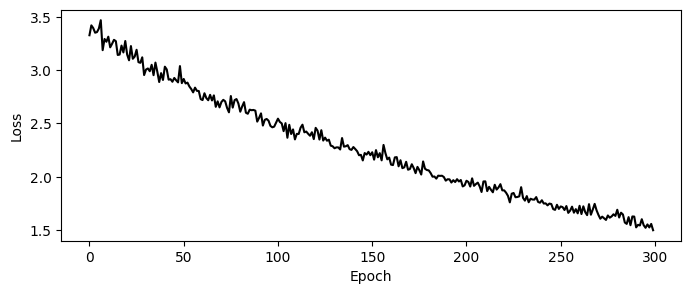

In [48]:
plt.figure(figsize=(8,3))
plt.plot(total_loss,'k')
plt.gca().set(xlabel='Epoch',ylabel='Loss')
plt.show()

In [50]:
X = tokenizer.encode('why did the chicken cross the road?', return_tensors='pt').to(device)
Y = gpt2.generate(X,do_sample= True, max_length=200)
print(textwrap.fill(tokenizer.decode(Y[0].tolist()),width=100))

# how many generated tokens contain a target letter
hasTarget = 0
for t in Y[0][len(X[0]):]:
    if 'x' in tokenizer.decode(t):
        hasTarget+=1

print(f'{hasTarget} of {len(Y[0][len(X[0]):])} tokens have a target.')
    

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


why did the chicken cross the road? The duck cross the sidewalk? The cat crossed the street? The
chicken crossed the street with me that i did the the fox crossedthe box crossthe border cross the
fence cross the fox crossexistexexexexexexexexistexecexecmaxoxmxmxmx Xmxmxoxmxmxmx
PhoenixXoxmxxmlexoxexexecxpExecmxxpxp xtxtxxxxxxxxxx Exxyxy cxmxxi cxmxxmx XoxxiXXmx oxxxx xx xx xx
xxXXxi xx X X X X XXXxi xx X x xx xxxxXXxx xx xx xx oxxesxxexxesexXxd Extxesxctxmxmxxc cxmxxmxxx xxx
xx xx Luxxml Xxx xxx xx Exxxx Xxx xx Xxx cxwxmxxmx xxi xx X XX xx xx xx xxx xx xxx xx xxxx XXxx xx
Xxx xx
136 of 192 tokens have a target.


In [51]:
# now change increase the lr
optimizer = torch.optim.AdamW(gpt2.parameters(), lr=1e-4, weight_decay=.01)
num_epochs = 300

total_loss= np.zeros(num_epochs)

for epoch in range(num_epochs):
    # init batch losses to accumulate

    #GENERATE data and move data to GPU
    X = torch.randint(0, tokenizer.vocab_size,(batch_size,seq_len)).to(device)

    # fwd pass
    optimizer.zero_grad()
    logits = gpt2(X)[0]

    logits_reshape = logits.view(-1,tokenizer.vocab_size)
    logprobs_reshape = F.log_softmax(logits_reshape, dim=-1)
    loss = loss_function(logprobs_reshape)

    loss.backward()
    optimizer.step()

    total_loss[epoch] =loss.item()

    if epoch%25==0:
        print(f'Finished epoch {epoch}, train loss: {total_loss[epoch]}')

X = tokenizer.encode('why did the chicken cross the road?', return_tensors='pt').to(device)
Y = gpt2.generate(X,do_sample= True, max_length=200)
print(textwrap.fill(tokenizer.decode(Y[0].tolist()),width=100))

# how many generated tokens contain a target letter
hasTarget = 0
for t in Y[0][len(X[0]):]:
    if 'x' in tokenizer.decode(t):
        hasTarget+=1

print(f'{hasTarget} of {len(Y[0][len(X[0]):])} tokens have a target.')

Finished epoch 0, train loss: 1.5390501022338867
Finished epoch 25, train loss: 0.09487709403038025
Finished epoch 50, train loss: 0.015421479940414429
Finished epoch 75, train loss: 0.007273132912814617
Finished epoch 100, train loss: 0.004755887668579817
Finished epoch 125, train loss: 0.0034043723717331886
Finished epoch 150, train loss: 0.0024169497191905975
Finished epoch 175, train loss: 0.0019531436264514923
Finished epoch 200, train loss: 0.0015007400652393699
Finished epoch 225, train loss: 0.001298645045608282
Finished epoch 250, train loss: 0.0013211636105552316
Finished epoch 275, train loss: 0.0009534746641293168


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


why did the chicken cross the road? Taxtax exploration Proxy axe exaltedtax fixme AlexisAlex
Excpixel ExplainRex fixme Examiner Maxnext Explorer xp Maxxb Alexander explorer
Explorerexpectedexplxb Exc Explorer Fox Exactly Oxxx taxable ox Pix Maximifax hoax Index Fairfaxox
Ox Explore boxxpRex taxable Voxindex Ox Explore dx taxable tax xx extrasFox fox Pix expensive
hexxietyhexexpensive boxesxit Exhibit Exodusdx exclude boxxious extras Explore
galaxyexceptifixexecute Expect Exhibitdxxus Apex galaxy dioxide extingu examiner Exploreifixifax Exc
Expend extingxitexmx extrem Reduxexpected Extra WaxExec box nonex Extremxf ExileExecwxEx oxyex explo
ExhibitRexXbox box Waxexe boxesexpressexpectedixir existed boxes Wax galaxyexpl expectancy
expectancy Elixirexcept exploding boxes XboxExit existedxit examsxitExecutive oxLinux Explosexcept
boxesxusexpected BoxExecutive maximal boxes WaxExecutive dioxideFaxexpectedexaspxExpress
excuseDexexpected BoxExecutive oxExc extingu Excnoxiousnox boxexistentexex

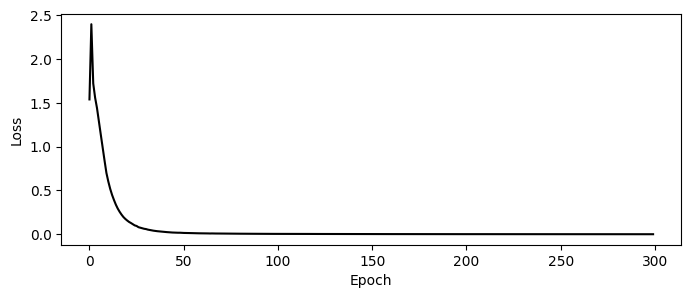

In [52]:
plt.figure(figsize=(8,3))
plt.plot(total_loss,'k')
plt.gca().set(xlabel='Epoch',ylabel='Loss')
plt.show()